<h1> import libraries

In [ ]:
import matplotlib.pyplot as plt 
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet  import DenseNet169
from tensorflow.keras.applications.vgg19  import VGG19

from tensorflow.keras import Model
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Flatten ,Dropout , Dense  ,Conv2D , MaxPooling2D ,BatchNormalization 
import numpy as np 
import pandas as pd 
import cv2 as cv

In [2]:
image = plt.imread("../input/kermany2018/OCT2017 /train/DME/DME-1072015-1.jpeg")
plt.imshow(image,cmap='gray')
image=cv.resize(image,(300,300))
image=image.reshape(300,300,1)
image.shape

<h1> Explore data 

In [3]:
TrainPath="../input/kermany2018/OCT2017 /train/"
TestPath="../input/kermany2018/OCT2017 /test/"
ValidationPath="../input/kermany2018/OCT2017 /val/"

print(TrainPath)
print(TestPath)
print(ValidationPath)

../input/kermany2018/OCT2017 /train/
../input/kermany2018/OCT2017 /test/
../input/kermany2018/OCT2017 /val/


the numbers of images in DME class :  11348
(512, 512)


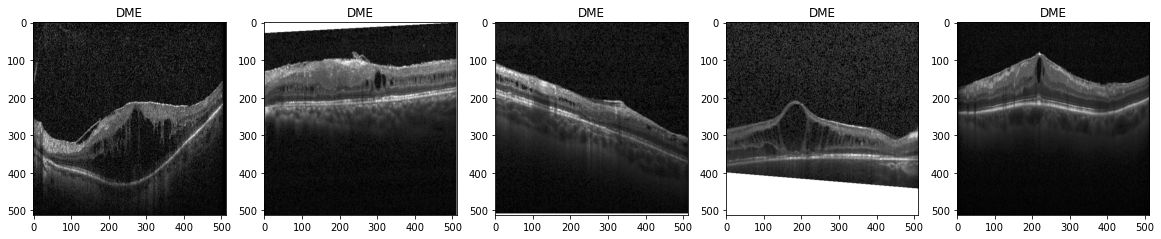

the numbers of images in DRUSEN class :  8616
(496, 768)


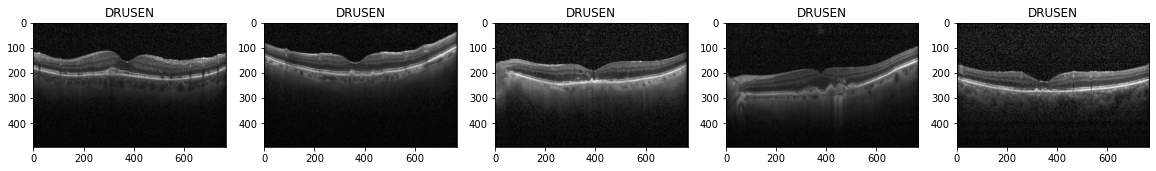

the numbers of images in CNV class :  37205
(496, 768)


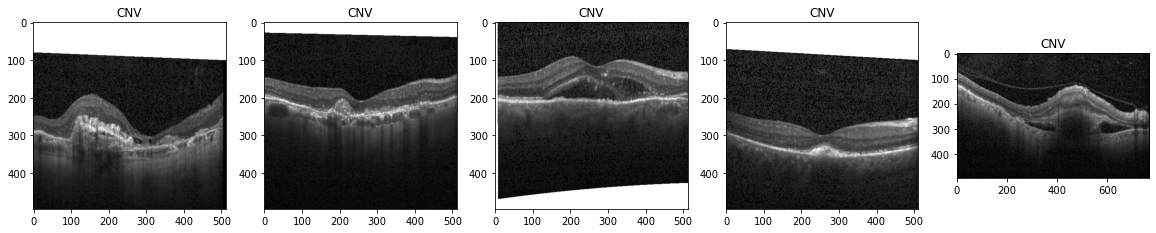

the numbers of images in NORMAL class :  26315
(496, 768)


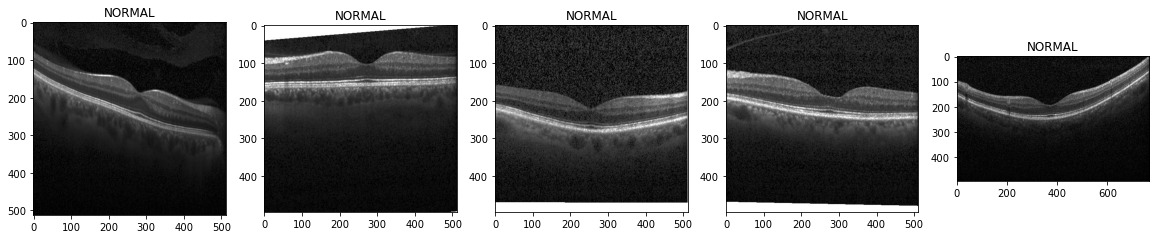

In [16]:
trainClass=os.listdir(TrainPath)
for i in range(len(trainClass)):
    imageInfile=[]
    imageInfile=os.listdir(os.path.join(TrainPath,trainClass[i]))
    print( f"the numbers of images in {trainClass[i]} class : " , len(imageInfile))
    plt.figure(figsize=(20,20))
    for j in range(5):
        
        plt.subplot(1,5,j+1)
        image=plt.imread(os.path.join(os.path.join(TrainPath,trainClass[i]),imageInfile[j]))
        plt.title(trainClass[i])
        plt.imshow(image,cmap='gray')
    print(image.shape)
    plt.show()

<h2>after explore dataset we show these images arenot in the same size and same scale </h2>
    the dataset isnot balance , Unfortunately the dataset imbalance 
    I use the Data Augmentation to read , resize , rescale and balance dataset(but we not do this now) 

<h1>DataAugmentation

In [4]:

imageDelegate=ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    
    )


In [13]:
ImageSize=224
trainGenerator=imageDelegate.flow_from_directory(
    TrainPath,
    batch_size=50,
    target_size=(ImageSize,ImageSize)  
)

testGenerator =imageDelegate.flow_from_directory(
     TestPath,
     batch_size= 10,
     target_size=(ImageSize, ImageSize)
)

validationGenerator =imageDelegate.flow_from_directory(
     ValidationPath,
     batch_size=4,
     target_size=(ImageSize, ImageSize)
)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [19]:
Labels={0:"BME",1:"CNV",2:"DRUSEN",3:"NORMAL"}
def GetLabel(key):
    return Labels[key]


print(GetLabel(0))
print(GetLabel(1))
print(GetLabel(2))
print(GetLabel(3))

BME
CNV
DRUSEN
NORMAL


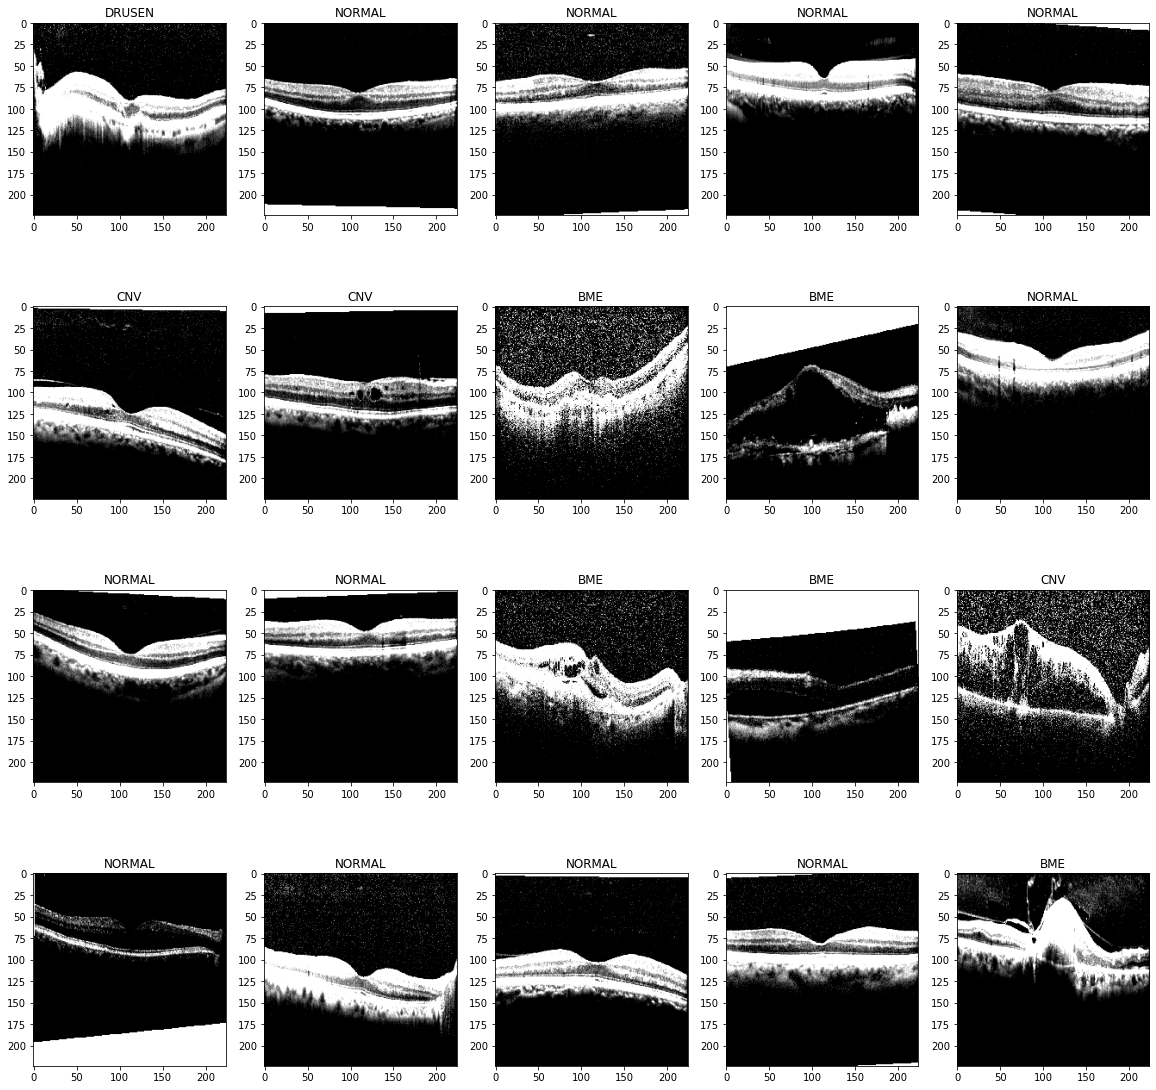

In [20]:
plt.figure(figsize=(20,20))
for i  in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(trainGenerator.__getitem__(0)[0][i])
    plt.title(GetLabel(np.argmax(trainGenerator.__getitem__(0)[1][i])))
    
    


In [21]:
trainGenerator.__getitem__(0)[0][1].shape

(224, 224, 3)

<h1>Build Models

<h1>Densesnet 

In [14]:
preTrainedModelDenseNet169 = DenseNet169(input_shape =( ImageSize, ImageSize, 3), include_top = False, 
weights = None
                                        )
preTrainedModelDenseNet169.load_weights("../input/densenet-keras/DenseNet-BC-169-32-no-top.h5")
for layer in preTrainedModelDenseNet169.layers:
    layer.trainable = False  
preTrainedModelDenseNet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block22_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block22_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block22_1_relu (Activatio (None, 7, 7, 128)    0           conv5_block22_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block22_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block22_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block22_concat (Concatena (None, 7, 7, 1344)   0           conv5_block21_concat[0][0]       
                                                                 conv5_block22_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block23_0_bn (BatchNormal (None, 7, 7, 1344)   5376        conv5_block22_concat[0][0]       
__________

In [15]:

#DenseNet169 Model
x=Flatten()(preTrainedModelDenseNet169.output)

#Fully Connection Layers
# FC1
x=Dense(1024, activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(512, activation="relu")(x)
#Dropout to avoid overfitting effect
x=Dropout(0.2)(x)
# FC2
x=Dense(256, activation="relu")(x)
x=Dense(128, activation="relu")(x)


#output layer
x=Dense(4,activation="sigmoid")(x)


modelDenesNet=Model(preTrainedModelDenseNet169.input,x)
modelDenesNet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

Total params: 96,830,404
Trainable params: 84,185,476
Non-trainable params: 12,644,928
__________________________________________________________________________________________________


In [27]:
#Optimzation
modelDenesNet.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

epochs=20

#Fit model  """83484/50=1670 steps_per_epoch=the number of image /batch size"""
history=modelDenesNet.fit_generator(trainGenerator,epochs=epochs,steps_per_epoch=835,validation_data=validationGenerator ,validation_steps=8,verbose=1 )

Epoch 1/20
835/835 [==============================] - 660s 790ms/step - loss: 0.1569 - accuracy: 0.8777 - val_loss: 0.1441 - val_accuracy: 0.8750
Epoch 2/20
835/835 [==============================] - 481s 576ms/step - loss: 0.1129 - accuracy: 0.9147 - val_loss: 0.1491 - val_accuracy: 0.9062
Epoch 3/20
835/835 [==============================] - 488s 585ms/step - loss: 0.0962 - accuracy: 0.9274 - val_loss: 0.1229 - val_accuracy: 0.9688
Epoch 4/20
835/835 [==============================] - 481s 576ms/step - loss: 0.0840 - accuracy: 0.9376 - val_loss: 0.1109 - val_accuracy: 0.9375
Epoch 5/20
835/835 [==============================] - 481s 576ms/step - loss: 0.0729 - accuracy: 0.9456 - val_loss: 0.1633 - val_accuracy: 0.9375
Epoch 6/20
835/835 [==============================] - 480s 575ms/step - loss: 0.0620 - accuracy: 0.9542 - val_loss: 0.1672 - val_accuracy: 0.9375
Epoch 7/20
835/835 [==============================] - 477s 571ms/step - loss: 0.0540 - accuracy: 0.9584 - val_loss: 0.1509 -

In [28]:
modelDenesNet.save("modelDenesNet.h5")

In [29]:
modelDenesNet.evaluate(testGenerator)

97/97 [==============================] - 7s 75ms/step - loss: 0.0382 - accuracy: 0.9897


[0.038201313465833664, 0.9896694421768188]

- the Accuracy and Loss for DenesNet169 Model With 20 Epochs


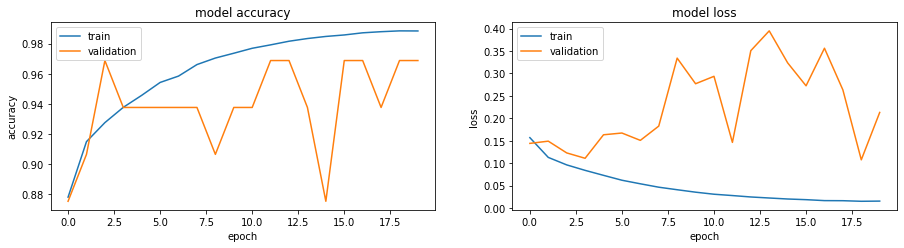

In [30]:
print("- the Accuracy and Loss for DenesNet169 Model With 20 Epochs")
plt.figure(figsize=(40,20))
# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

<h1>

<h1>VGG19 model

In [5]:
preTrainedModelVGG19 = VGG19(input_shape =( ImageSize, ImageSize, 3), include_top = False)
# preTrainedModelVGG19.load_weights("../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")
for layer in preTrainedModelVGG19.layers:
    layer.trainable = False  
preTrainedModelVGG19.summary()
from tensorflow.keras import Model

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [6]:

#mobileNet Model
x=Flatten()(preTrainedModelVGG19.output)

#Fully Connection Layers
# FC1
x=Dense(1024, activation="relu")(x)
x=Dense(512, activation="relu")(x)
#Dropout to avoid overfitting effect
x=Dropout(0.2)(x)
# FC2
x=Dense(256, activation="relu")(x)
x=Dense(128, activation="relu")(x)


#output layer
x=Dense(4,activation="sigmoid")(x)


ModelVGG19=Model(preTrainedModelVGG19.input,x)
ModelVGG19.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
#Optimzation
ModelVGG19.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])
epochs=20
#Fit model
historyModelVGG19=ModelVGG19.fit_generator(trainGenerator,epochs=epochs,steps_per_epoch=835,validation_data=validationGenerator ,validation_steps=8,verbose=1 )

Epoch 1/20
835/835 [==============================] - 445s 532ms/step - loss: 0.0277 - accuracy: 0.9796 - val_loss: 0.1158 - val_accuracy: 0.9688
Epoch 2/20
835/835 [==============================] - 437s 523ms/step - loss: 0.0254 - accuracy: 0.9811 - val_loss: 0.1242 - val_accuracy: 0.9688
Epoch 3/20
835/835 [==============================] - 439s 526ms/step - loss: 0.0242 - accuracy: 0.9818 - val_loss: 0.0838 - val_accuracy: 0.9688
Epoch 4/20
835/835 [==============================] - 436s 522ms/step - loss: 0.0216 - accuracy: 0.9839 - val_loss: 0.0966 - val_accuracy: 0.9688
Epoch 5/20
835/835 [==============================] - 433s 519ms/step - loss: 0.0218 - accuracy: 0.9836 - val_loss: 0.1063 - val_accuracy: 0.9688
Epoch 6/20
835/835 [==============================] - 437s 523ms/step - loss: 0.0222 - accuracy: 0.9836 - val_loss: 0.1428 - val_accuracy: 0.9375
Epoch 7/20
835/835 [==============================] - 438s 525ms/step - loss: 0.0205 - accuracy: 0.9846 - val_loss: 0.1443 -

In [10]:
ModelVGG19.save("ModelVGG19.h5")

In [12]:
ModelVGG19.evaluate(testGenerator)

97/97 [==============================] - 6s 62ms/step - loss: 0.0492 - accuracy: 0.9886


[0.04923604428768158, 0.9886363744735718]

- the Accuracy and Loss for vgg19 Model With 20 Epochs


NameError: name 'historyModelVGG19' is not defined

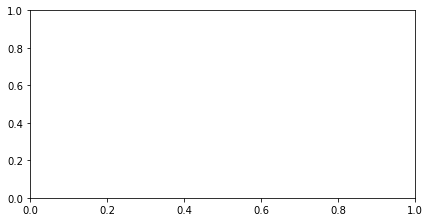

In [1]:
print("- the Accuracy and Loss for vgg19 Model With 20 Epochs")
plt.figure(figsize=(40,20))
# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(historyModelVGG19.history['accuracy'])
plt.plot(historyModelVGG19.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(historyModelVGG19.history['loss'])
plt.plot(historyModelVGG19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

<h1>MobileNet model

In [7]:
from tensorflow.keras.applications.mobilenet  import MobileNet
preTrainedModelMobileNet = MobileNet(input_shape =( ImageSize, ImageSize, 3), include_top = False)
for layer in preTrainedModelMobileNet.layers:
    layer.trainable = False  
preTrainedModelMobileNet.summary()
from tensorflow.keras import Model


17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [8]:
#MobileNet Model
x=Flatten()(preTrainedModelMobileNet.output)

#Fully Connection Layers
# FC1
x=Dense(1024, activation="relu")(x)
x=Dense(512, activation="relu")(x)
#Dropout to avoid overfitting effect
x=Dropout(0.2)(x)

x=Dense(256, activation="relu")(x)

# FC2
x=Dense(128, activation="relu")(x)


#output layer
x=Dense(4,activation="sigmoid")(x)


ModelMobileNet=Model(preTrainedModelMobileNet.input,x)
ModelMobileNet.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [9]:
#Optimzation
ModelMobileNet.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

#Fit model
historyModelMobileNet=ModelMobileNet.fit_generator(trainGenerator,epochs=epochs,steps_per_epoch=835 ,validation_data=validationGenerator,validation_steps=8 ,verbose=1 )

Epoch 1/20
835/835 [==============================] - 937s 1s/step - loss: 0.2334 - accuracy: 0.8643 - val_loss: 0.0769 - val_accuracy: 0.9062
Epoch 2/20
835/835 [==============================] - 550s 659ms/step - loss: 0.1114 - accuracy: 0.9169 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 3/20
835/835 [==============================] - 547s 656ms/step - loss: 0.0848 - accuracy: 0.9380 - val_loss: 0.1050 - val_accuracy: 0.9375
Epoch 4/20
835/835 [==============================] - 532s 637ms/step - loss: 0.0699 - accuracy: 0.9484 - val_loss: 0.1418 - val_accuracy: 0.9375
Epoch 5/20
835/835 [==============================] - 494s 591ms/step - loss: 0.0573 - accuracy: 0.9586 - val_loss: 0.0756 - val_accuracy: 0.9688
Epoch 6/20
835/835 [==============================] - 508s 609ms/step - loss: 0.0475 - accuracy: 0.9657 - val_loss: 0.0339 - val_accuracy: 0.9688
Epoch 7/20
835/835 [==============================] - 515s 617ms/step - loss: 0.0396 - accuracy: 0.9721 - val_loss: 0.0224 - va

In [10]:
ModelMobileNet.save("ModelMobileNet.h5")

In [11]:
ModelMobileNet.evaluate(testGenerator)

97/97 [==============================] - 6s 64ms/step - loss: 0.0550 - accuracy: 0.9783


[0.05502396076917648, 0.9783057570457458]

- the Accuracy and Loss for MobileNet Model With 10 Epochs


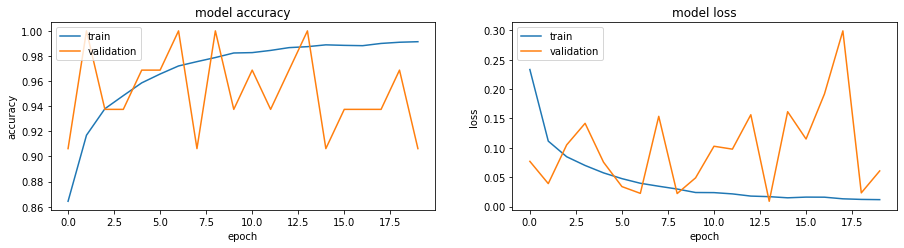

In [12]:
print("- the Accuracy and Loss for MobileNet Model With 10 Epochs")
plt.figure(figsize=(40,20))
# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(historyModelMobileNet.history['accuracy'])
plt.plot(historyModelMobileNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(historyModelMobileNet.history['loss'])
plt.plot(historyModelMobileNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()